In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/opencv2/master/opencv-master/.editorconfig
/kaggle/input/opencv2/master/opencv-master/LICENSE
/kaggle/input/opencv2/master/opencv-master/CMakeLists.txt
/kaggle/input/opencv2/master/opencv-master/README.md
/kaggle/input/opencv2/master/opencv-master/CONTRIBUTING.md
/kaggle/input/opencv2/master/opencv-master/data/readme.txt
/kaggle/input/opencv2/master/opencv-master/data/CMakeLists.txt
/kaggle/input/opencv2/master/opencv-master/data/haarcascades/haarcascade_frontalface_alt2.xml
/kaggle/input/opencv2/master/opencv-master/data/haarcascades/haarcascade_lefteye_2splits.xml
/kaggle/input/opencv2/master/opencv-master/data/haarcascades/haarcascade_profileface.xml
/kaggle/input/opencv2/master/opencv-master/data/haarcascades/haarcascade_frontalface_alt_tree.xml
/kaggle/input/opencv2/master/opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml
/kaggle/input/opencv2/master/opencv-master/data/haarcascades/haarcascade_righteye_2splits.xml
/kaggle/input/opencv2/master/opencv-mas

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def data_loader(file):
    # Load dataset file
    data_frame = pd.read_csv(file)
    
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    return imgs_array, labels_array

In [3]:
######   BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL    ########


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
# from keras.optimizers import Adam


# Main model
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model


X_train, y_train = data_loader('/kaggle/input/facial-points-localization/training.csv')
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 300
batch_size = 64

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('model1.h5')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Train on 1712 samples, validate on 428 samples
Epoch 1/300
1712/1712 [==============================] - 5s 3ms/step - loss: 0.0214 - acc: 0.5257 - val_loss: 0.0084 - val_acc: 0.4322

Epoch 00001: val_loss improved from inf to 0.00845, saving model to checkpoint1.hdf5
Epoch 2/300
1712/1712 [==============================] - 0s 200us/step - loss: 0.0059 - acc: 0.6898 - val_loss: 0.0075 - val_acc: 0.4322

Epoch 00002: val_loss improved from 0.00845 to 0.00750, saving model to checkpoint1.hdf5
Epoch 3/300
1712/1712 [==============================] - 0s 191us/step - loss: 0.0052 - acc: 0.7225 - val_loss: 0.0077 - val_acc: 0.4322

Epoch 00003: val_loss did not improve from 0.00750
Epoch 4/300
1712/1712 [==============================] - 0s 188us/step - loss: 0.0048 - acc: 0.7307 - val_loss: 0.0079 - val_acc: 0.4322

Epoch 00004: val_loss did not improve from 0.00750
Epoch 5/300
1712/1712

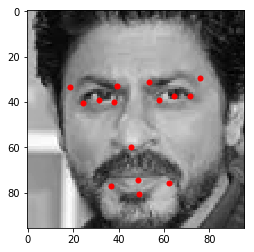

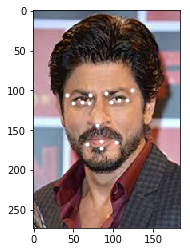

In [4]:
#####  TEST YOUR IMAGE FILE WITH THE MODEL  #####
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier('../input/opencv2/master/opencv-master/data/haarcascades/haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('/kaggle/input/images/index.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.1, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()

0.23627305030822754
0.09228634834289551
0.08342957496643066
0.08328747749328613
0.09895038604736328
0.0826566219329834
0.08393120765686035
0.08390450477600098
0.08303070068359375
0.08211064338684082
0.08243751525878906
0.08240270614624023
0.08362030982971191
0.0823209285736084
0.08556795120239258
0.08492255210876465
0.10042595863342285
0.08260560035705566
0.08489394187927246
0.08328580856323242
0.0824441909790039
0.0826108455657959
0.08191657066345215
0.08269882202148438
0.08345890045166016
0.08231377601623535
0.08207821846008301
0.08436942100524902
0.08504128456115723
0.0946044921875
0.08442068099975586
0.08289146423339844
0.08173942565917969
0.08294224739074707
0.08203339576721191
0.0814061164855957
0.08281326293945312
0.0813591480255127
0.08234047889709473
0.08348560333251953
0.08231735229492188
0.10106110572814941
0.08412051200866699
0.08205103874206543
0.08258771896362305
0.0826120376586914
0.0823521614074707
0.08213090896606445
0.08426213264465332
0.10252141952514648
0.0920138359

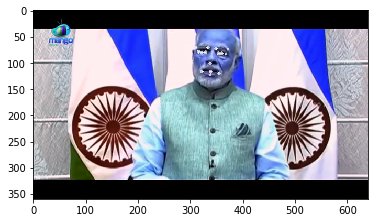

In [5]:
####  TEST YOUR VIDEO FILE WITH THE MODEL  #####


from keras.models import load_model
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time



model = load_model('model1.h5')  # <-- Saved model path


# input video file path
input_file = '../input/modispeech/PM Narendra Modi Speech On Demonetisation On New Years Eve  Part 1  Mango News.mp4'


# output file path
output_filename = 'testVideo_out.avi'  


def get_points_main(img):

    def detect_points(face_img):
        me  = np.array(face_img)/255
        x_test = np.expand_dims(me, axis=0)
        x_test = np.expand_dims(x_test, axis=3)

        y_test = model.predict(x_test)
        label_points = (np.squeeze(y_test)*48)+48


        return label_points

    # load haarcascade
    face_cascade = cv2.CascadeClassifier('../input/opencv2/master/opencv-master/data/haarcascades/haarcascade_frontalface_default.xml')
    dimensions = (96, 96)


    try:
        default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(default_img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
#         faces = face_cascade.detectMultiScale(gray_img, 4, 6)

    except:
        return []

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False


    all_x_cords = []
    all_y_cords = []


    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        try:
            just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        except:
            return []
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)

        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)



    final_points_list = []
    try:
        for ii in range(len(all_x_cords)):
            for a_x, a_y in zip(all_x_cords[ii], all_y_cords[ii]):
                final_points_list.append([a_x, a_y])
    except:
        return final_points_list

    return final_points_list

# cap = cv2.VideoCapture(0)


cap = cv2.VideoCapture(input_file)
ret, frame = cap.read()
height, width, channel = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_filename, fourcc, 20.0, (width, height))


frame_no = 0
while cap.isOpened():

    a = time.time()
    
    frame_no += 1
    ret, frame = cap.read()
    if frame_no > 75*30:
        break
    if frame_no in range(60*30, 75*30):
        points = get_points_main(frame)

        try:
            overlay = frame.copy()
        except Exception as e:
            print(e)
            break

        for point in points:

            cv2.circle(frame, tuple(point), 3, (255, 255, 255), -1)
            # cv2.line(frame, last_point, tuple(point), (0,0,255), thickness=1)
            # cv2.putText(overlay, str(i), tuple(point), 1, 1, (255, 255, 255))

        if len(points) != 0:
            o_line_points = [[12,13], [13,11], [11,14], [14,12], [12,10], [11,10], [10,3], [12,5], [11,3], [10,5], [10,4], [10,2], [5,1], [1,4], [2,0], [0,3], [5,9], [9,8], [8,4], [2,6], [6,7], [7,3]]
            num_face = len(points)//15

            for i in range(num_face):
                line_points = np.array(o_line_points) + (15*(i))

                the_color = (189, 195, 199)

                for ii in line_points:
                    cv2.line(overlay, tuple(points[ii[0]]), tuple(points[ii[1]]), the_color, thickness=1)


        opacity = 0.3
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)
        out.write(frame)
        plt.imshow(frame)
        b = time.time()
        print(str((b-a)))
cap.release()


In [6]:
os.listdir()

['__notebook__.ipynb',
 'checkpoint1.hdf5',
 'model1.h5',
 '__output__.json',
 'testVideo_out.avi']

In [7]:
from IPython.display import HTML
def create_download_link(title, filename):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)
create_download_link("Download video file",'testVideo_out.avi')